In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import script
import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import subprocess
import os
import pickle
import json 

def save_runs(exp_root, exp_name, runs, args):
    git_hash = script.get_git_revision_hash()
    dirty = b'script.py' in subprocess.check_output(['git', 'diff', '--name-only'])
    exp_root = os.path.join(exp_root, f'{git_hash}-dirty' if dirty else f'{git_hash}')
    exp_dir = os.path.join(exp_root, exp_name)
    os.makedirs(exp_dir)
    with open(os.path.join(exp_dir, 'results'), 'wb') as f:
        pickle.dump(runs, f)
    with open(os.path.join(exp_dir, 'args' ), 'w') as f:
        json.dump(vars(args), f, indent=True, sort_keys=True)

## harris et. al setup with selection

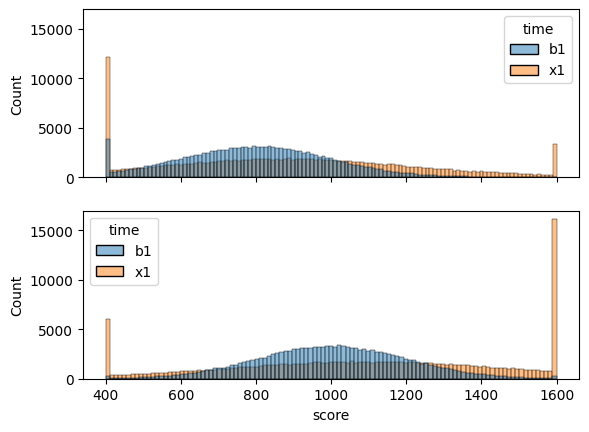

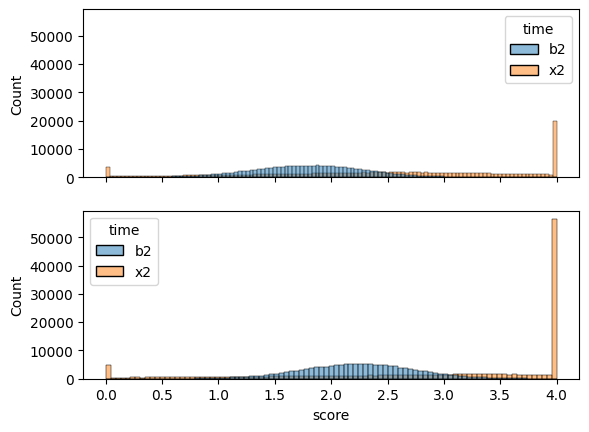

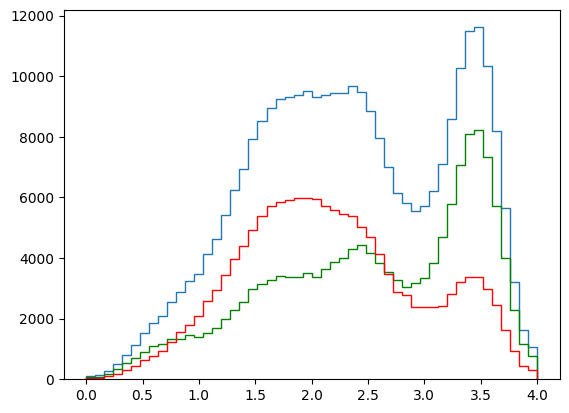

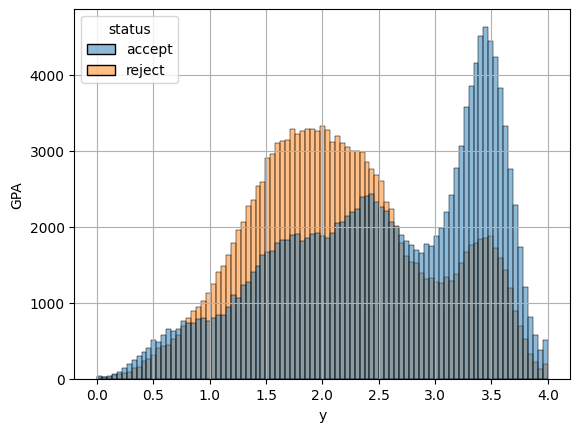

In [14]:
# plot data.
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --clip'
args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

df0 = pd.DataFrame(
    {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], 'x1': x[adv_idx, 0], 'x2': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df
dflong = pd.melt(df, id_vars=('class'), value_vars=('b1', 'x1'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

dflong = pd.melt(df, id_vars=('class'), value_vars=('b2', 'x2'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
# fig,ax=plt.subplots()
# sns.histplot(df,x='y_hat',ax=ax)
# sns.histplot(df[df.status==1], x='y_hat', ax=ax)

fig,ax=plt.subplots()
plt.hist(y[0],  histtype='step', bins=50)
plt.hist(y[0][z==1],  histtype='step', color='g', bins=50)
plt.hist(y[0][z==0], histtype='step', color='r', bins=50)

dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
dfa['status'] = 'accept'
dfr['status'] = 'reject'
df = pd.concat((dfa, dfr))
fig,ax=plt.subplots()
sns.histplot(df, x='y', hue='status', ax=ax)
ax.set_ylabel('GPA')
ax.grid()

# sns.histplot(df, x='y', ax=ax)

In [16]:
n_runs = 10
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --clip --methods ols 2sls'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )

299it [00:09, 32.04it/s]
278it [00:08, 16.64it/s]
299it [00:10, 29.57it/s]
299it [00:10, 29.14it/s]
299it [00:10, 29.54it/s]
299it [00:10, 29.28it/s]
299it [00:09, 30.07it/s]
299it [00:10, 29.64it/s]
299it [00:11, 25.69it/s]
299it [00:10, 29.82it/s]


In [20]:
# save_runs('experiments', 'harris-with-selection', runs, args)
#with open('/home/maadil/strategic-iv/experiments/38f2b2def647847bd85caa97013d0f522014871e/harris-with-selection/results', 'rb') as f:
    #runs = pickle.load(f)
# runs
# with open('/home/maadil/strategic-iv/experiments/f711f06/harris-with-selection/results', 'rb') as f:
    # runs = pickle.load(f)
# runs 

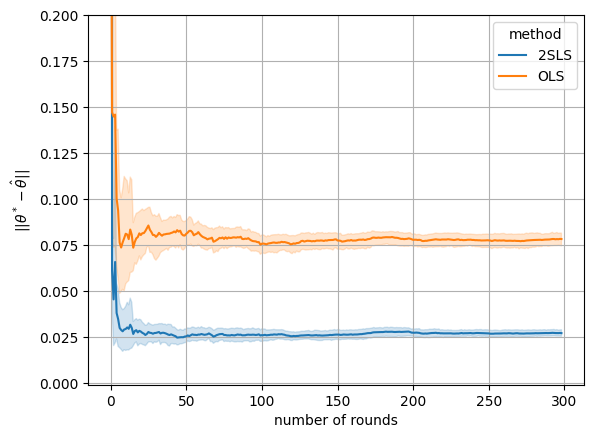

In [18]:
# converting to long format.
df = script.runs2df(runs)
dflong = pd.melt(df, id_vars='iterations', value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
dflong['method'] = dflong['method'].astype('category')
dflong['method']= dflong['method'].cat.rename_categories({'ols_env0':'OLS', '2sls_env0': '2SLS'})

# plot
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.set_ylabel(r'$||\theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')
ax.grid()

## our setup.

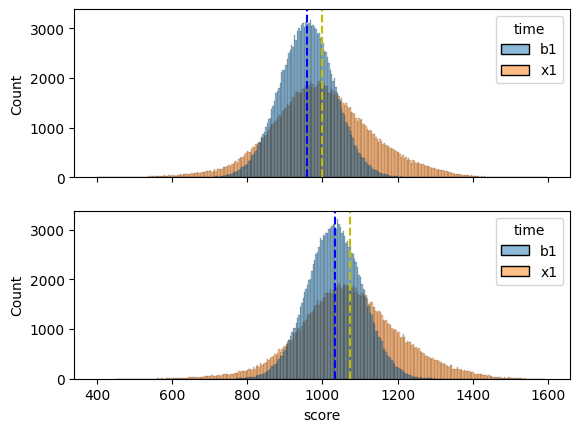

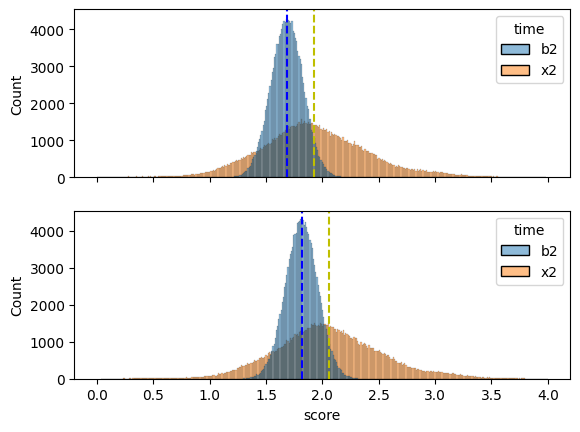

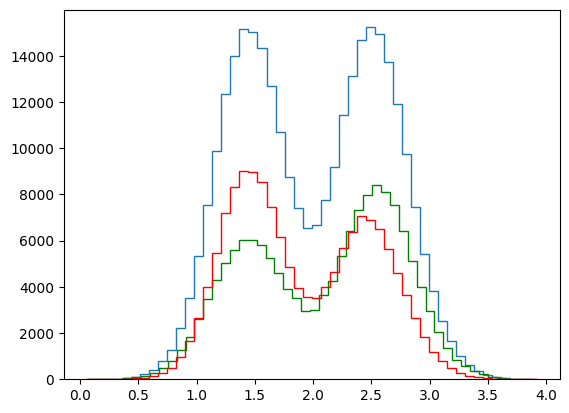

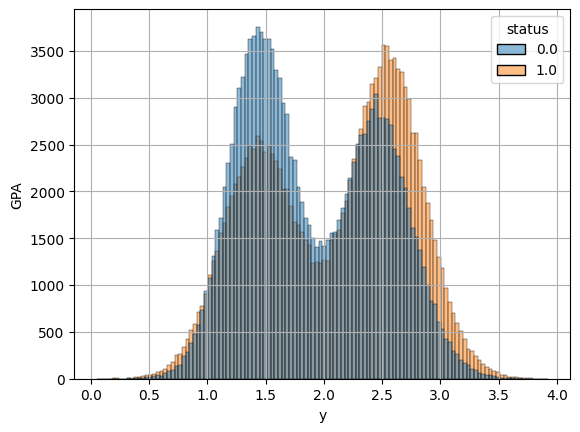

In [21]:
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq'

args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

df0 = pd.DataFrame(
    {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], 'x1': x[adv_idx, 0], 'x2': x[adv_idx, 1], 'y_hat': y_hat[0, disadv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))

# SAT score
dflong = pd.melt(df, id_vars=('class'), value_vars=('b1', 'x1'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='b1')].score.mean(), color='b', linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='x1')].score.mean(), color='y', linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='b1')].score.mean(), color='b', linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='x1')].score.mean(), color='y', linestyle='--')

# GPA
dflong = pd.melt(df, id_vars=('class'), value_vars=('b2', 'x2'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='b2')].score.mean(), color='b', linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time=='x2')].score.mean(), color='y', linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='b2')].score.mean(), color='b', linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time=='x2')].score.mean(), color='y', linestyle='--')

# College GPA (the target)
fig,ax=plt.subplots()
plt.hist(y[0],  histtype='step', bins=50)
plt.hist(y[0][z==1],  histtype='step', color='g', bins=50)
plt.hist(y[0][z==0], histtype='step', color='r', bins=50)

dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd
fig,ax=plt.subplots()
sns.histplot(df, x='y', hue='status', ax=ax)
ax.set_ylabel('GPA')
ax.grid()

# sns.histplot(df, x='y', ax=ax)

In [22]:
n_runs = 10
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )

299it [00:13, 22.84it/s]
275it [00:10, 13.12it/s]
290it [00:12, 12.65it/s]
299it [00:13, 22.82it/s]
299it [00:12, 23.57it/s]
299it [00:13, 22.34it/s]
299it [00:13, 22.83it/s]
299it [00:12, 23.03it/s]
299it [00:12, 23.46it/s]
299it [00:12, 23.45it/s]


In [26]:
# save_runs('experiments', 'our-settings', runs, args)
# with open('experiments/f711f06/our-settings/results', 'rb') as f:
  # runs = pickle.load(f)
# runs

In [24]:
df = script.runs2df(runs)
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong 
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'ours_vseq': 'Ours', 'ols': 'OLS', '2sls': '2SLS'})
dflong

,iterations,env,error,method
0,0,env0,0.170022,2SLS
1,1,env0,0.005948,2SLS
2,2,env0,0.024151,2SLS
3,3,env0,0.105895,2SLS
4,4,env0,0.123728,2SLS
...,...,...,...,...
8965,294,env0,0.002558,Ours
8966,295,env0,0.002558,Ours
8967,296,env0,0.002594,Ours
8968,297,env0,0.002594,Ours


Text(0.5, 0, 'number of rounds')

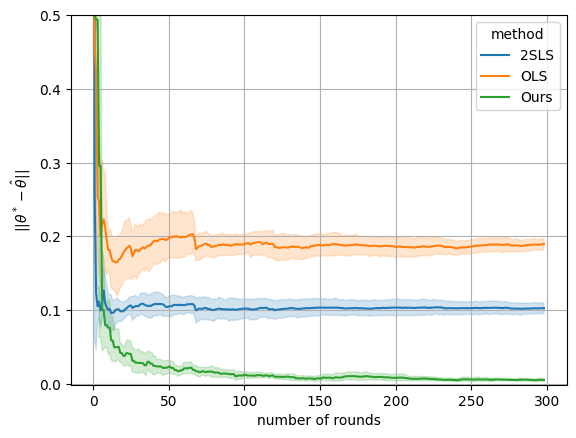

In [25]:
# dflong = pd.melt(df, id_vars='iterations', value_vars=('ours_env0', 'ours_env1'), var_name='env', value_name='error')
fig,ax=plt.subplots()
sns.lineplot(dflong, x='iterations', y='error', errorbar=('ci', 95), ax=ax, hue='method')
ax.grid()
ax.set_ylim(bottom=-0.001, top=.5)
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

## multiple envs clone.

In [27]:
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 2'
args = script.get_args(cmd)


In [28]:
n_runs = 10
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )

269it [00:08, 15.92it/s]
296it [00:10, 15.79it/s]
299it [00:10, 28.47it/s]
299it [00:10, 29.89it/s]
292it [00:09, 15.71it/s]
299it [00:10, 28.73it/s]
126it [00:01, 43.38it/s]
299it [00:10, 27.86it/s]
299it [00:10, 28.09it/s]
299it [00:10, 28.91it/s]
299it [00:10, 29.45it/s]
299it [00:09, 29.93it/s]
262it [00:07, 18.35it/s]
299it [00:10, 29.43it/s]

299it [00:10, 29.87it/s]
299it [00:10, 29.61it/s]
299it [00:09, 29.95it/s]
299it [00:09, 29.93it/s]
299it [00:09, 30.41it/s]


In [34]:
# save_runs('experiments', 'multi-env-clone', runs, args)
# with open('experiments/f711f06/multi-env-clone/results', 'rb') as f:
  # runs = pickle.load(f)

In [31]:
df = script.runs2df(runs)
df
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong

,iterations,env,error,method
0,0,env0,0.929815,2sls
1,1,env0,0.038139,2sls
2,2,env0,0.024613,2sls
3,3,env0,0.046343,2sls
4,4,env0,0.058248,2sls
...,...,...,...,...
17935,294,env1,0.025568,ours_vseq
17936,295,env1,0.025568,ours_vseq
17937,296,env1,0.024754,ours_vseq
17938,297,env1,0.024754,ours_vseq


Text(0.5, 0, 'number of rounds')

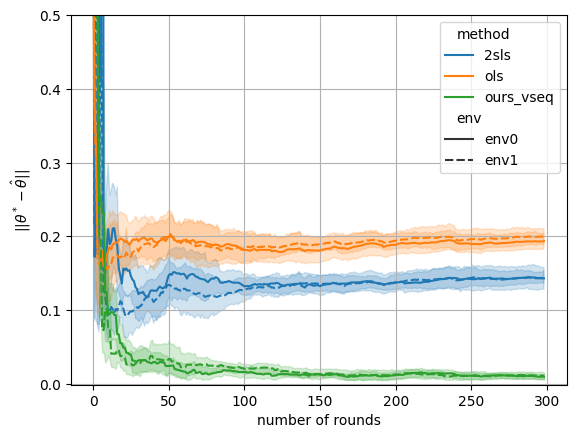

In [32]:
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='env', errorbar=('ci', 95), ax=ax)
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

## multi envs.

In [6]:
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs 3 --theta-star-std .1 --envs-accept-rates .2 .6 1'
args = script.get_args(cmd)
np.random.seed(999)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

In [17]:
def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d

# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df

,b1,b2,status,y,y_hat,x1,x2,y_env0,y_env1,y_env2,w_env0,w_env1,w_env2,class
0,835.179617,1.152691,0.0,1.697035,1.143023,873.737340,2.153987,1.697035,1.992951,1.604638,0.0,0.0,0.0,disadv
1,1007.028333,1.260120,0.0,1.413659,-1.110339,952.461732,1.901412,1.413659,1.609140,1.208869,0.0,0.0,0.0,disadv
2,828.289453,1.302596,0.0,1.197751,-0.134972,930.517352,1.497002,1.197751,1.158651,1.449069,0.0,0.0,0.0,disadv
3,1012.515534,1.361039,2.0,0.878581,-0.604641,1069.953422,0.655119,0.878581,0.878722,0.873822,0.0,1.0,1.0,disadv
4,735.329192,1.184878,1.0,1.360161,-0.601429,635.457743,1.860433,1.360161,1.586480,1.529250,1.0,0.0,1.0,disadv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,1070.344848,1.288607,2.0,2.840096,1.021654,1064.392456,2.347312,2.840096,2.845171,2.691164,0.0,1.0,0.0,adv
149996,1164.340353,1.196079,3.0,2.587541,-1.067729,1146.676389,1.908542,2.587541,2.698466,2.150443,0.0,0.0,1.0,adv
149997,1003.859725,1.762451,2.0,2.439367,0.612951,1122.967292,2.035711,2.439367,2.768115,2.674404,1.0,1.0,1.0,adv
149998,1051.587745,1.359581,2.0,2.445884,-0.760108,1034.017866,1.700235,2.445884,2.200938,2.454099,0.0,1.0,0.0,adv


/home/maadil/anaconda3/envs/strategic-iv/lib/python3.7/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/maadil/anaconda3/envs/strategic-iv/lib/python3.7/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


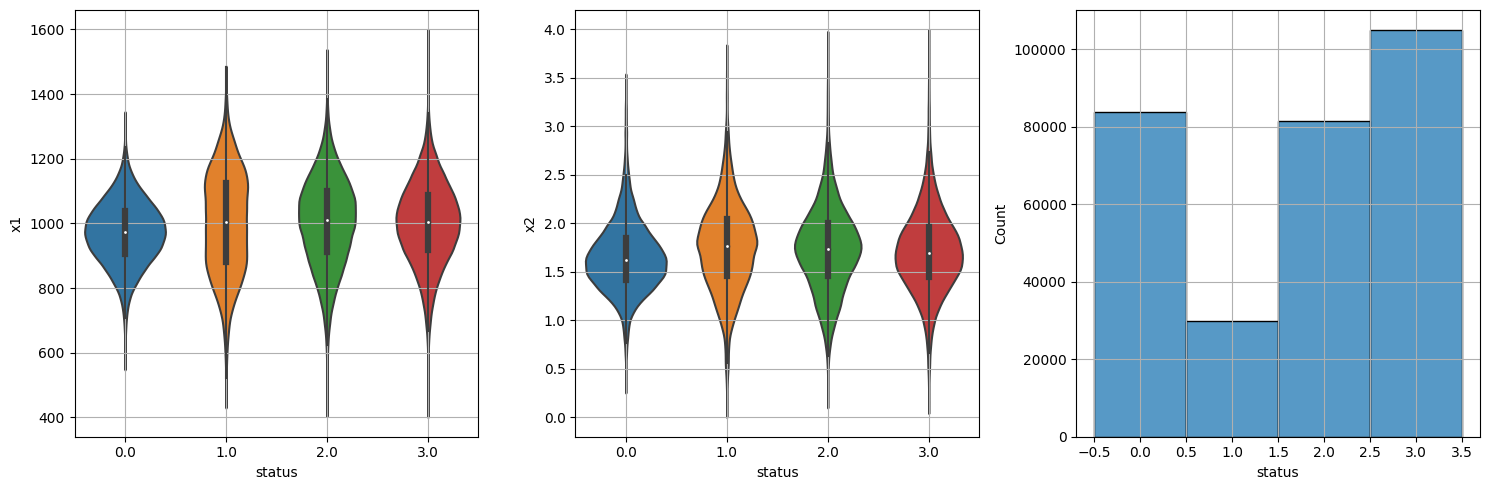

In [18]:
fig,ax=plt.subplots(ncols=3, figsize=(15, 5))
sns.violinplot(df, x='status', y='x1', cut=0, ax=ax[0])
sns.violinplot(df, x='status', y='x2', cut=0, ax=ax[1])
# sns.violinplot(df, x='status', y='y', cut=0, ax=ax[2])
sns.histplot(df, x='status', bins='auto', ax=ax[2])
for _ax in ax:
    _ax.grid()
plt.tight_layout()

In [10]:
df[df.w_env0==1][['x2']].mean() , df[df.w_env1==1][['x2']].mean() , df[df.w_env2==1][['x2']].mean() , df[df.w_env0==1][['x1']].mean() , df[df.w_env1==1][['x1']].mean() , df[df.w_env2==1][['x1']].mean() 

(x2    1.836395
 dtype: float64,
 x2    1.785315
 dtype: float64,
 x2    1.754415
 dtype: float64,
 x1    1015.075326
 dtype: float64,
 x1    1011.176473
 dtype: float64,
 x1    1007.932379
 dtype: float64)

In [12]:
# _dfs = []
# for env_idx in range(args.num_envs):
  
  # df_env = df[(df[f'w_env{env_idx}']==1)][['x1', 'x2', 'y_env0', 'y_env1', 'y_env2']]
  # df_env['w'] = env_idx
  # _dfs.append(df_env)
# _dfs = pd.concat(_dfs)

# fig,ax=plt.subplots(ncols=3, figsize=(15, 5))
# sns.violinplot(_dfs, x='w', y='x1', cut=0, ax=ax[0])
# sns.violinplot(_dfs, x='w', y='x2', cut=0, ax=ax[1])
# _dfs.groupby('w').mean()


In [13]:
n_runs = 10
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(script.run_multi_env, args_list )

299it [00:05, 57.88it/s] 
176it [00:01, 63.38it/s]
299it [00:05, 56.33it/s]
266it [00:04, 36.03it/s]
299it [00:05, 58.09it/s]
299it [00:05, 57.14it/s]
299it [00:05, 55.56it/s]
299it [00:05, 56.62it/s]
299it [00:05, 57.13it/s]
299it [00:05, 57.12it/s]
299it [00:08, 36.29it/s]
257it [00:05, 23.56it/s]
286it [00:07, 18.32it/s]
134it [00:02, 38.05it/s]
299it [00:08, 35.70it/s]
292it [00:08, 19.36it/s]
299it [00:08, 36.33it/s]
292it [00:08, 17.93it/s]
299it [00:08, 36.04it/s]
299it [00:08, 35.76it/s]
299it [00:10, 29.18it/s]
299it [00:10, 28.99it/s]
299it [00:09, 30.52it/s]
299it [00:09, 30.33it/s]
299it [00:09, 30.21it/s]
299it [00:09, 31.25it/s]
299it [00:09, 30.95it/s]
299it [00:09, 30.58it/s]
299it [00:10, 29.46it/s]
299it [00:09, 29.93it/s]


In [16]:
# save_runs('experiments', 'multi-envs', runs, args)

Text(0.5, 0, 'number of rounds')

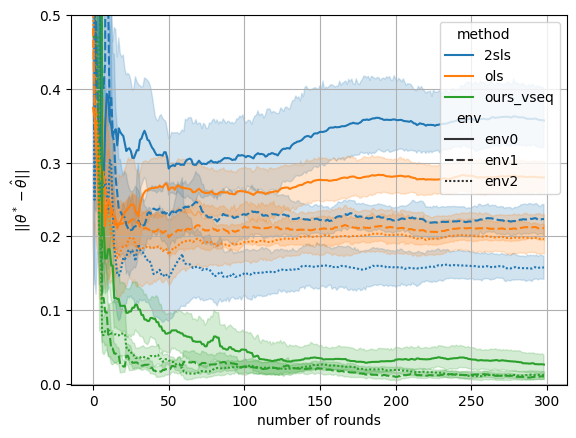

In [14]:
df = script.runs2df(runs)
df
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='env', errorbar=('ci', 95), ax=ax)
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

In [19]:
## selection function variation. 
n_envs = 2
dfs = []
for env0_accept_rate in (0.2, .4, .6, .8, 1.):
    envs_accept_rates = np.linspace(env0_accept_rate, 1, num=n_envs)
    envs_accept_rates = [str(x) for x in envs_accept_rates]
    envs_accept_rates =' '.join(envs_accept_rates)
    
    cmd =f'--offline-eval --num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours_vseq --num-envs {n_envs} --theta-star-std .1 --envs-accept-rates {envs_accept_rates}'
    args = script.get_args(cmd)

    n_runs = 10
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(script.run_multi_env, args_list )
    df = script.runs2df(runs)
    df['env0_accept_rate'] = env0_accept_rate

    dfs.append(df)
df = pd.concat(dfs)

1it [00:00, 15.96it/s]
1it [00:00,  6.96it/s]
1it [00:00, 12.22it/s]
1it [00:00, 10.22it/s]
1it [00:00, 13.96it/s]
1it [00:00,  9.22it/s]
1it [00:00, 16.71it/s]
1it [00:00,  7.64it/s]
1it [00:00, 10.54it/s]
0it [00:00, ?it/s]t/s]
1it [00:00,  7.62it/s]
1it [00:00,  5.83it/s]
1it [00:00,  4.92it/s]
1it [00:00, 10.91it/s]
1it [00:00,  5.52it/s]
1it [00:00, 11.25it/s]
1it [00:00, 12.99it/s]
1it [00:00,  8.08it/s]
1it [00:00, 13.90it/s]
1it [00:00, 11.04it/s]
1it [00:00,  6.07it/s]
1it [00:00, 12.51it/s]

1it [00:00,  7.59it/s]

1it [00:00, 10.72it/s]
1it [00:00,  8.00it/s]
1it [00:00, 11.11it/s]
1it [00:00,  8.55it/s]
1it [00:00, 11.65it/s]
1it [00:00,  5.93it/s]
1it [00:00,  5.24it/s]

1it [00:00, 11.91it/s]
0it [00:00, ?it/s]t/s]
1it [00:00, 10.12it/s]
1it [00:00,  5.92it/s]
1it [00:00,  7.31it/s]
1it [00:00,  5.67it/s]
1it [00:00, 17.26it/s]
1it [00:00, 10.38it/s]
1it [00:00, 11.73it/s]
1it [00:00, 10.81it/s]
1it [00:00, 11.91it/s]
1it [00:00,  4.87it/s]
1it [00:00,  4.79it/s]
1it [00:

In [23]:
# save_runs('experiments', 'selection-rate', df, args)

<AxesSubplot:xlabel='env0_accept_rate', ylabel='error'>

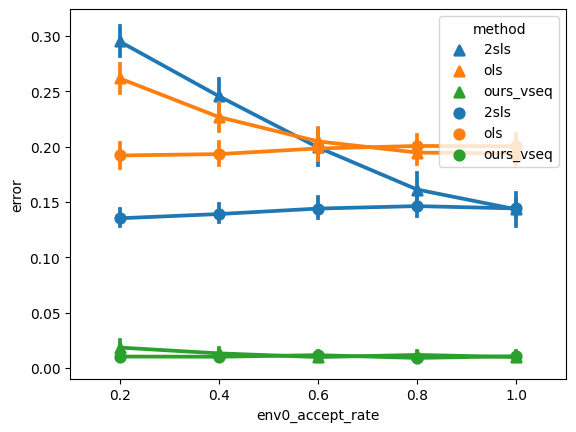

In [20]:
value_vars = [f'{m}_env{ei}' for m in args.methods for ei in range(args.num_envs)]
value_vars
dflong = pd.melt(df, id_vars='env0_accept_rate', value_vars=value_vars, value_name='error', var_name='method_env')
dflong['method'] = dflong.method_env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.method_env.apply(lambda x:x.split('_')[-1])  

dflong
fig,ax=plt.subplots()
sns.pointplot(data=dflong[dflong.env=='env0'], x='env0_accept_rate', y='error', hue='method', markers='^')
# sns.pointplot(data=dflong[dflong.env=='env1'], x='env0_accept_rate', y='error', hue='method', markers='x')
sns.pointplot(data=dflong[dflong.env=='env1'], x='env0_accept_rate', y='error', hue='method', markers='o')



In [ ]:
# theta changing. 

## protocol vs. no protocol

In [24]:
_runs = []
for protocol in (True, False):
    # cmd = f'--num-applicants 300000 --applicants-per-round 1000 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --methods ours'
    
    cmd = f'--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours_vseq --num-envs 2 --theta-star-std .1 --envs-accept-rates 1'
    if not protocol:
        cmd = f'{cmd} --no-protocol'
    print(cmd)
    
    args = script.get_args(cmd)
    n_runs = 10
    args_list = [(s, args, 0) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(script.run_multi_env, args_list )
        _runs.append(runs)

--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours_vseq --num-envs 2 --theta-star-std .1 --envs-accept-rates 1


299it [00:04, 61.38it/s] 
299it [00:04, 61.34it/s]
276it [00:04, 36.86it/s]
299it [00:04, 60.72it/s]
289it [00:04, 34.63it/s]
299it [00:04, 60.87it/s]
299it [00:04, 62.02it/s]
299it [00:05, 59.00it/s]
299it [00:04, 62.36it/s]
299it [00:05, 59.51it/s]


--num-applicants 300000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours_vseq --num-envs 2 --theta-star-std .1 --envs-accept-rates 1 --no-protocol


299it [00:04, 66.83it/s] 
299it [00:04, 60.80it/s] 
299it [00:04, 63.87it/s]
197it [00:02, 59.67it/s]]
299it [00:04, 63.26it/s] 
299it [00:04, 63.50it/s]
299it [00:04, 64.51it/s]
299it [00:04, 63.97it/s]
299it [00:04, 62.94it/s]
299it [00:04, 62.96it/s]


In [27]:
df0 = script.runs2df(_runs[0])
df1 = script.runs2df(_runs[1])
df0['protocol'] = True
df1['protocol'] = False
df = pd.concat((df0, df1))
df

,iterations,ours_vseq_env0,protocol
0,0,0.676405,True
1,1,0.676405,True
2,2,0.676398,True
3,3,0.676398,True
4,4,0.005103,True
...,...,...,...
2985,294,0.045516,False
2986,295,0.045516,False
2987,296,0.046167,False
2988,297,0.046167,False


In [30]:
# save_runs('experiments', 'protocol', df, args)

Text(0, 0.5, '$ || \\theta^* - \\hat{\\theta}|| $')

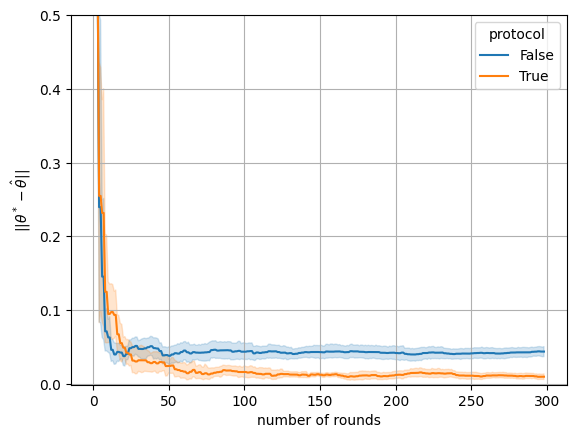

In [28]:
fig,ax=plt.subplots()
sns.lineplot(data=df.reset_index(), x='iterations', y='ours_vseq_env0', hue='protocol')
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_xlabel('number of rounds')
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')

In [ ]:
from sklearn.linear_model import LinearRegression

cmd =f'--num-applicants 10000 --applicants-per-round 100 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours 2sls ols'
args = script.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args, _theta_star=0.5
    )


def our_vseq(x, y, w, applicants_per_round):
    assert x.ndim == 2
    n_applicants = x.shape[0]
  
    idx1, idx2, idx3 = 0, 0, 0
  
    A, b = [], []
    for t in range(0, n_applicants, applicants_per_round*2):
      w_t1 = w[t:t+applicants_per_round]
      w_t2 = w[t+applicants_per_round:t+applicants_per_round+applicants_per_round]

      x_t1 = x[t:t+applicants_per_round][w_t1 == 1]
      x_t2 = x[t+applicants_per_round:t+applicants_per_round+applicants_per_round][w_t2 == 1]

      idx2 = int(idx1 + w_t1.sum())
      idx3 = int(idx2 + w_t2.sum())

      y_t1 = y[idx1:idx2]
      y_t2 = y[idx2:idx3]

      b.append(y_t2.mean() - y_t1.mean())
      A.append(
    x_t1.mean(axis=0, keepdims=True) - x_t2.mean(axis=0, keepdims=True)
  )

      idx1 = idx3
  
    assert idx1 == y.size, f'{idx1}, {y.size}'
    A , b= np.concatenate(A, axis=0), np.concatenate(b)
  
    m = LinearRegression()
    m.fit(A, b)

our_vseq(args, x, y, w)

In [ ]:
np.random.normal(loc=5, scale=0, size=(100,))

In [ ]:
test = np.random.normal(size=(1000, 3, 2))

In [ ]:
np.transpose(test, axes=(0, 2, 1)).shape